# Trust Scores algorithm Applied to MNIST dataset

It is important to know when a machine learning classifier’s predictions can be trusted. Relying on the classifier’s (uncalibrated) prediction probabilities is not optimal and can be improved upon. Trust scores measure the agreement between the classifier and a modified nearest neighbor classifier on the test set. The trust score is the ratio between the distance of the test instance to the nearest class different from the predicted class and the distance to the predicted class. Higher scores correspond to more trustworthy predictions. A score of 1 would mean that the distance to the predicted class is the same as to another class.

The original paper on which the algorithm is based is called [To Trust Or Not To Trust A Classifier](https://arxiv.org/abs/1805.11783). The implementation borrows heavily from https://github.com/google/TrustScore, as does the example notebook.

Trust scores work best for low to medium dimensional feature spaces. This notebook illustrates how you can **apply trust scores to high dimensional data** like images by adding an additional pre-processing step in the form of an [**auto-encoder**](https://en.wikipedia.org/wiki/Autoencoder) to reduce the dimensionality. Other dimension reduction techniques like **PCA** can be used as well.

**References**: 
* https://docs.seldon.io/projects/alibi/en/stable/examples/trustscore_mnist.html

In [1]:
import alibi

List of the latest available model explanation algorithms

In [2]:
alibi.explainers.__all__

['ALE',
 'AnchorTabular',
 'DistributedAnchorTabular',
 'AnchorText',
 'AnchorImage',
 'CEM',
 'CounterFactual',
 'CounterFactualProto',
 'plot_ale',
 'IntegratedGradients']

Model confidence

In [3]:
alibi.confidence.__all__

['linearity_measure', 'LinearityMeasure', 'TrustScore']

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from alibi.confidence import TrustScore

Load the data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


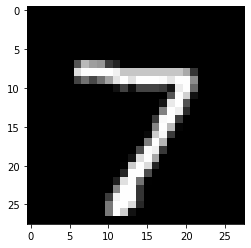

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[0]);

Prepare data: scale, reshape and categorize

In [6]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [7]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

## Define and train model

Create a simple softmax classifier

In [8]:
def sc_model():
    x_in = Input(shape=(28, 28, 1))
    x = Flatten()(x_in)
    x_out = Dense(10, activation='softmax')(x)
    sc = Model(inputs=x_in, outputs=x_out)
    sc.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return sc

Initiate and print model's summary

In [9]:
sc = sc_model()
sc.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Train the model

In [10]:
sc.fit(x_train, y_train, batch_size=128, epochs=5);

Epoch 1/5
469/469 [==============================] - 9s 14ms/step - loss: 1.6183 - accuracy: 0.5551
Epoch 2/5
469/469 [==============================] - 6s 14ms/step - loss: 0.7474 - accuracy: 0.8360
Epoch 3/5
469/469 [==============================] - 7s 15ms/step - loss: 0.5924 - accuracy: 0.8559
Epoch 4/5
469/469 [==============================] - 6s 14ms/step - loss: 0.5246 - accuracy: 0.8699
Epoch 5/5
469/469 [==============================] - 7s 15ms/step - loss: 0.4814 - accuracy: 0.8763


Evaluate the model on the test set

In [11]:
score = sc.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.8845000267028809


## Define and train auto-encoder

In [12]:
def ae_model():
    # encoder
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(4, (3, 3), activation=None, padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    encoder = Model(x_in, encoded)

    # decoder
    dec_in = Input(shape=(4, 4, 4))
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(dec_in)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)
    decoder = Model(dec_in, decoded)

    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

Initiate the models

In [13]:
ae, enc, dec = ae_model()

In [14]:
ae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_1 (Functional)         (None, 4, 4, 4)           1612      
_________________________________________________________________
model_2 (Functional)         (None, 28, 28, 1)         1757      
Total params: 3,369
Trainable params: 3,369
Non-trainable params: 0
_________________________________________________________________


Train the model

In [15]:
ae.fit(x_train, x_train, batch_size=128, epochs=8, validation_data=(x_test, x_test))

Epoch 1/8
469/469 [==============================] - 122s 241ms/step - loss: 0.0869 - val_loss: 0.0420
Epoch 2/8
469/469 [==============================] - 109s 233ms/step - loss: 0.0398 - val_loss: 0.0347
Epoch 3/8
469/469 [==============================] - 113s 240ms/step - loss: 0.0337 - val_loss: 0.0299
Epoch 4/8
469/469 [==============================] - 101s 216ms/step - loss: 0.0296 - val_loss: 0.0270
Epoch 5/8
469/469 [==============================] - 93s 198ms/step - loss: 0.0270 - val_loss: 0.0255
Epoch 6/8
469/469 [==============================] - 83s 177ms/step - loss: 0.0255 - val_loss: 0.0243
Epoch 7/8
469/469 [==============================] - 79s 168ms/step - loss: 0.0244 - val_loss: 0.0235
Epoch 8/8
469/469 [==============================] - 74s 158ms/step - loss: 0.0238 - val_loss: 0.0231


Save the models of the auto-encoder and the encoder

In [16]:
ae.save('mnist_ae.h5')
enc.save('mnist_enc.h5')

Load the models of the auto-encoder and the encoder

In [17]:
ae = load_model('mnist_ae.h5')
enc = load_model('mnist_enc.h5')

## Trust Scores

Initialize trust scores

In [18]:
ts = TrustScore()

The key is to **fit and calculate the trust scores on the encoded instances**. The encoded data still needs to be reshaped from (60000, 4, 4, 4) to (60000, 64) to comply with the **k-d tree** format. This is handled internally

In [19]:
x_train_enc = enc.predict(x_train)
ts.fit(x_train_enc, y_train, classes=10)  # 10 classes present in MNIST

Reshaping data from (60000, 4, 4, 4) to (60000, 64) so k-d trees can be built.


Calculate the trust scores and closest not predicted classes of the predictions on the test set, using the distance to the 5th nearest neighbor in each class:

In [20]:
n_samples = 1000 # calculate the trust scores for the first 1000 predictions on the test set
x_test_enc = enc.predict(x_test[:n_samples])
y_pred = sc.predict(x_test[:n_samples])
score, closest_class = ts.score(x_test_enc[:n_samples], y_pred, k=5)

Reshaping data from (1000, 4, 4, 4) to (1000, 64) so k-d trees can be queried.


Inspect which predictions have low and high trust scores

In [21]:
n = 5

In [22]:
# lowest and highest trust scores
idx_min, idx_max = np.argsort(score)[:n], np.argsort(score)[-n:]
score_min, score_max = score[idx_min], score[idx_max]
closest_min, closest_max = closest_class[idx_min], closest_class[idx_max]
pred_min, pred_max = y_pred[idx_min], y_pred[idx_max]
imgs_min, imgs_max = x_test[idx_min], x_test[idx_max]
label_min, label_max = np.argmax(y_test[idx_min], axis=1), np.argmax(y_test[idx_max], axis=1)

In [23]:
# model confidence percentiles
max_proba = y_pred.max(axis=1)

In [24]:
# low score high confidence examples
idx_low = np.where((max_proba>0.80) & (max_proba<0.9) & (score<1))[0][:n]
score_low = score[idx_low]
closest_low = closest_class[idx_low]
pred_low = y_pred[idx_low]
imgs_low = x_test[idx_low]
label_low = np.argmax(y_test[idx_low], axis=1)

### Low Trust Scores

The image below makes clear that the low trust scores correspond to misclassified images. Because the trust scores are significantly below 1, they correctly identified that the images belong to another class than the predicted class, and identified that class.

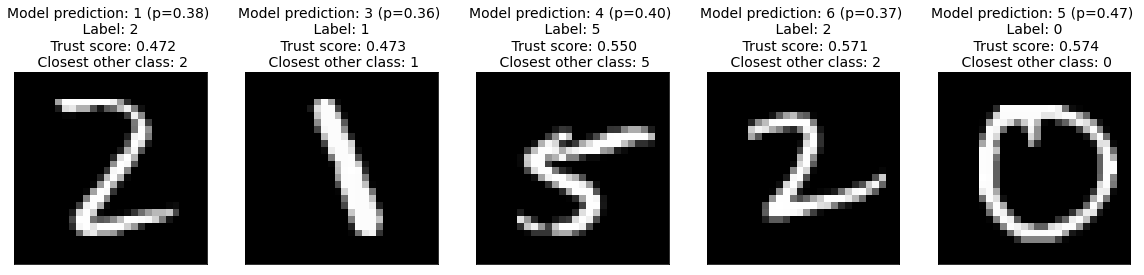

In [25]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(imgs_min[i].reshape(28, 28))
    plt.title('Model prediction: {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}' \
              '\n Closest other class: {}'.format(pred_min[i].argmax(),pred_min[i].max(),
                                                  label_min[i], score_min[i], closest_min[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### High Trust Scores

The high trust scores on the other hand all are very clear 1’s

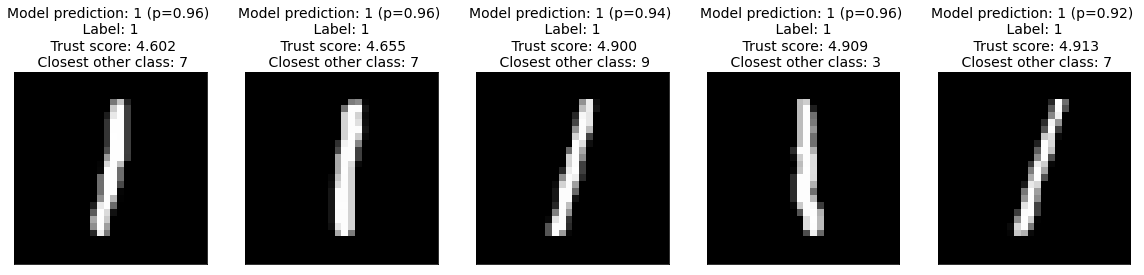

In [26]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(imgs_max[i].reshape(28, 28))
    plt.title('Model prediction: {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}' \
              '\n Closest other class: {}'.format(pred_max[i].argmax(),pred_max[i].max(),
                                                  label_max[i], score_max[i], closest_max[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### High model confidence, low trust score

Where trust scores really matter is when the predicted model confidence is relatively high (e.g. 𝑝∈[0.8,0.9]) but the corresponding trust score is low, this can indicate samples for which the model is overconfident.The trust score provides a diagnostic for finding these examples:

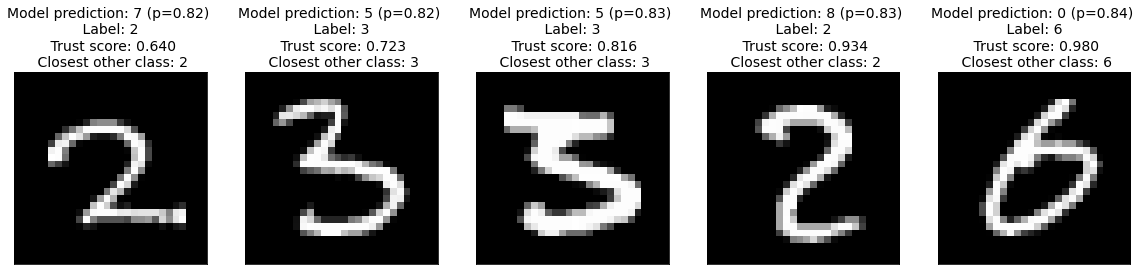

In [27]:
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(imgs_low[i].reshape(28, 28))
    plt.title('Model prediction: {} (p={:.2f}) \n Label: {} \n Trust score: {:.3f}' \
              '\n Closest other class: {}'.format(pred_low[i].argmax(),pred_low[i].max(),
                                                  label_low[i], score_low[i], closest_low[i]), fontsize=14)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can see several examples of an over-confident model predicting the wrong class, the low trust score, however, reveals that this is happening and the predictions should not be trusted despite the high model confidence.

In the following section we will see that on average trust scores outperform the model confidence for identifying correctly classified samples.

## Comparison of Trust Scores with model prediction probabilities

Let’s compare the prediction probabilities from the classifier with the trust scores for each prediction by checking whether trust scores are better than the model’s prediction probabilities at identifying correctly classified examples.

First we need to set up a couple of helper functions:

* Define a function that handles model training and predictions

In [28]:
def run_sc(X_train, y_train, X_test):
    clf = sc_model()
    clf.fit(X_train, y_train, batch_size=128, epochs=5, verbose=0)
    y_pred_proba = clf.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    probas = y_pred_proba[range(len(y_pred)), y_pred]  # probabilities of predicted class
    return y_pred, probas

* Define the function that generates the precision plots

In [29]:
def plot_precision_curve(plot_title,
                         percentiles,
                         labels,
                         final_tp,
                         final_stderr,
                         final_misclassification,
                         colors = ['blue', 'darkorange', 'brown', 'red', 'purple']):

    plt.title(plot_title, fontsize=18)
    colors = colors + list(cm.rainbow(np.linspace(0, 1, len(final_tp))))
    plt.xlabel("Percentile", fontsize=14)
    plt.ylabel("Precision", fontsize=14)

    for i, label in enumerate(labels):
        ls = "--" if ("Model" in label) else "-"
        plt.plot(percentiles, final_tp[i], ls, c=colors[i], label=label)
        plt.fill_between(percentiles,
                         final_tp[i] - final_stderr[i],
                         final_tp[i] + final_stderr[i],
                         color=colors[i],
                         alpha=.1)

    if 0. in percentiles:
        plt.legend(loc="lower right", fontsize=14)
    else:
        plt.legend(loc="upper left", fontsize=14)
    model_acc = 100 * (1 - final_misclassification)
    plt.axvline(x=model_acc, linestyle="dotted", color="black")
    plt.show()

* The function below trains the model on a number of folds, makes predictions, calculates the trust scores, and generates the precision curves to compare the trust scores with the model prediction probabilities:

In [30]:
def run_precision_plt(X, y, nfolds, percentiles, run_model, test_size=.2,
                      plt_title="", plt_names=[], predict_correct=True, classes=10):

    def stderr(L):
        return np.std(L) / np.sqrt(len(L))

    all_tp = [[[] for p in percentiles] for _ in plt_names]
    misclassifications = []
    mult = 1 if predict_correct else -1

    folds = StratifiedShuffleSplit(n_splits=nfolds, test_size=test_size, random_state=0)
    for train_idx, test_idx in folds.split(X, y):
        # create train and test folds, train model and make predictions
        X_train, y_train = X[train_idx, :], y[train_idx, :]
        X_test, y_test = X[test_idx, :], y[test_idx, :]
        y_pred, probas = run_model(X_train, y_train, X_test)
        # target points are the correctly classified points
        y_test_class = np.argmax(y_test, axis=1)
        target_points = (np.where(y_pred == y_test_class)[0] if predict_correct else
                         np.where(y_pred != y_test_class)[0])
        final_curves = [probas]
        # calculate trust scores
        ts = TrustScore()
        ts.fit(enc.predict(X_train), y_train, classes=classes)
        scores, _ = ts.score(enc.predict(X_test), y_pred, k=5)
        final_curves.append(scores)  # contains prediction probabilities and trust scores
        # check where prediction probabilities and trust scores are above a certain percentage level
        for p, perc in enumerate(percentiles):
            high_proba = [np.where(mult * curve >= np.percentile(mult * curve, perc))[0] for curve in final_curves]
            if 0 in map(len, high_proba):
                continue
            # calculate fraction of values above percentage level that are correctly (or incorrectly) classified
            tp = [len(np.intersect1d(hp, target_points)) / (1. * len(hp)) for hp in high_proba]
            for i in range(len(plt_names)):
                all_tp[i][p].append(tp[i])  # for each percentile, store fraction of values above cutoff value
        misclassifications.append(len(target_points) / (1. * len(X_test)))

    # average over folds for each percentile
    final_tp = [[] for _ in plt_names]
    final_stderr = [[] for _ in plt_names]
    for p, perc in enumerate(percentiles):
        for i in range(len(plt_names)):
            final_tp[i].append(np.mean(all_tp[i][p]))
            final_stderr[i].append(stderr(all_tp[i][p]))

    for i in range(len(all_tp)):
        final_tp[i] = np.array(final_tp[i])
        final_stderr[i] = np.array(final_stderr[i])

    final_misclassification = np.mean(misclassifications)

    # create plot
    plot_precision_curve(plt_title, percentiles, plt_names, final_tp, final_stderr, final_misclassification)

### Detect correctly classified examples

The x-axis on the plot below shows the percentiles for the model prediction probabilities of the predicted class for each instance and for the trust scores. The y-axis represents the precision for each percentile. For each percentile level, we take the test examples whose trust score is above that percentile level and plot the percentage of those points that were correctly classified by the classifier. We do the same with the classifier’s own model confidence (i.e. softmax probabilities). For example, at percentile level 80, we take the top 20% scoring test examples based on the trust score and plot the percentage of those points that were correctly classified. We also plot the top 20% scoring test examples based on model probabilities and plot the percentage of those that were correctly classified. The vertical dotted line is the error of the classifier. The plots are an average over 2 folds of the dataset with 20% of the data kept for the test set.

The **Trust Score and Model Confidence curves** then show that the model precision is typically higher when using the trust scores to rank the predictions compared to the model prediction probabilities.

In [31]:
X = x_train
y = y_train
percentiles = [0 + 0.5 * i for i in range(200)]
nfolds = 2
plt_names = ['Model Confidence', 'Trust Score']
plt_title = 'MNIST -- Softmax Classifier -- Predict Correct'

Reshaping data from (48000, 4, 4, 4) to (48000, 64) so k-d trees can be built.
Reshaping data from (12000, 4, 4, 4) to (12000, 64) so k-d trees can be queried.
Reshaping data from (48000, 4, 4, 4) to (48000, 64) so k-d trees can be built.
Reshaping data from (12000, 4, 4, 4) to (12000, 64) so k-d trees can be queried.


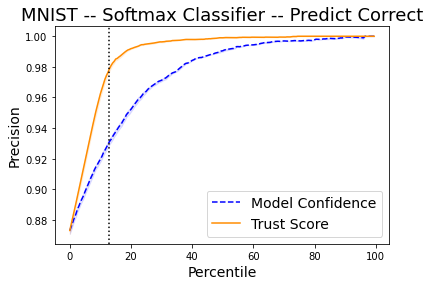

In [32]:
run_precision_plt(X, y, nfolds, percentiles, run_sc, plt_title=plt_title,
                  plt_names=plt_names, predict_correct=True)